## Data Importing & Exploration

In [15]:
import nibabel as nib
import numpy as np
import matplotlib.pyplot as plt
import random
#import cv2
import os
#import glob

In [12]:
# Reading in a single image and label
img = nib.load('./data/imagesTr/hippocampus_001.nii.gz')
label = nib.load('./data/labelsTr/hippocampus_001.nii.gz')

# Convert image to Numpy format
img_np = img.get_fdata()
label_np = label.get_fdata()

Text(0.5, 1.0, 'Label of Sagittal slice 14')

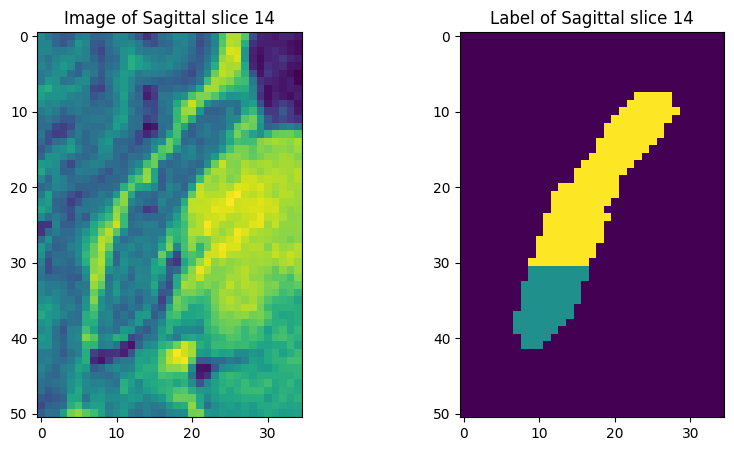

In [3]:
# Visualize the sagital slice 14
fig, axes = plt.subplots(1, 2, figsize=(10,5))
axes[0].imshow(img_np[14,:,:])
axes[0].set_title('Image of Sagittal slice 14')

axes[1].imshow(label_np[14,:,:])
axes[1].set_title('Label of Sagittal slice 14')

### Image Information, Volumetric & Area Calculation
We want to understand the data format of a single image (really a set of images that comprise a 3D representation).

** Adapted from ElliotY-ML's <a href="https://github.com/ElliotY-ML/Hippocampus_Segmentation_MRI/tree/master">Hippocampus_Segmentation_MRI Repo</a>



In [4]:
# **
# We know the images are in NIFTI format (.nii), but lets load in the metadata to confirm, and also get some spatial information about the images we are dealing with. 
# This will help with the later task of determining the hippocampal slice area in mm^2

print(f'Img: {img.header} \n')
print(f'Label: {label.header}')

Img: <class 'nibabel.nifti1.Nifti1Header'> object, endian='<'
sizeof_hdr      : 348
data_type       : b''
db_name         : b''
extents         : 0
session_error   : 0
regular         : b'r'
dim_info        : 0
dim             : [ 3 35 51 35  1  1  1  1]
intent_p1       : 0.0
intent_p2       : 0.0
intent_p3       : 0.0
intent_code     : none
datatype        : uint8
bitpix          : 8
slice_start     : 0
pixdim          : [1. 1. 1. 1. 1. 0. 0. 0.]
vox_offset      : 0.0
scl_slope       : nan
scl_inter       : nan
slice_end       : 0
slice_code      : unknown
xyzt_units      : 10
cal_max         : 0.0
cal_min         : 0.0
slice_duration  : 0.0
toffset         : 0.0
glmax           : 0
glmin           : 0
descrip         : b'5.0.10'
aux_file        : b'none'
qform_code      : scanner
sform_code      : scanner
quatern_b       : 0.0
quatern_c       : 0.0
quatern_d       : 0.0
qoffset_x       : 1.0
qoffset_y       : 1.0
qoffset_z       : 1.0
srow_x          : [1. 0. 0. 1.]
srow_y          :

* xyzt_units indicate the unit of measurement for dim. 10 in binary -> 2. 2 corresponds to unit: mm
* pixdim indicate the voxel dimensions of the scan.
    * Voxel Dims: [1, 1, 1, 1, 1, 0, 0, 0]
        * First value (1) is unused
        * Next 3 values (1, 1, 1) specify the size of the voxels along each dimension.
        * Last 3 values (0, 0, 0) are used for timing in fMRI scans - not applicable.

#### Note:

Knowing that one voxel dimension translates to a slice, and that each voxel represents one mm^3 in space makes out subsequent work much easier! No need to convert values to get the right units.

In [5]:
# Volume of first HPC:

voxel_volume = np.prod(label.header.get_zooms()[:3])
num_voxels = np.count_nonzero(label_np)

print(f'Total volume of the HPC is: {voxel_volume * num_voxels} mm^3')

slice_voxels = np.count_nonzero(label_np[14,:,:])

print(f'Total area of the 14th sagittal slice of the HPC is: {1 * slice_voxels} mm^2')

Total volume of the HPC is: 2948.0 mm^3
Total area of the 14th sagittal slice of the HPC is: 250 mm^2


### Loading all Sagittal Slices

In [11]:
# Directories containing the images and labels
image_dir = './data/imagesTr'
label_dir = './data/labelsTr'

# Function to load NIfTI images
def load_nifti_image(file_path):
    img = nib.load(file_path)
    return img.get_fdata()

# Lists to store images and labels
images = []
labels = []

slice_images = []
slice_labels = []

# Iterate through the files in the directories
for file_name in sorted(os.listdir(image_dir)):
    if file_name.endswith('.nii.gz'):
        image_path = os.path.join(image_dir, file_name)
        label_path = os.path.join(label_dir, file_name)  # Assuming the label file has the same name
        
        # Load the images and labels
        img_np = load_nifti_image(image_path)
        label_np = load_nifti_image(label_path)

        # Append the images and labels to the list
        images.append(img_np)
        labels.append(label_np)

        # Extract the 14th sagittal slice
        slice_img = img_np[14, :, :]
        slice_label = label_np[14, :, :]
        
        # Append the slices to the lists
        slice_images.append(slice_img)
        slice_labels.append(slice_label)

assert(len(slice_images) == len())

## Visualization of Slice Subset

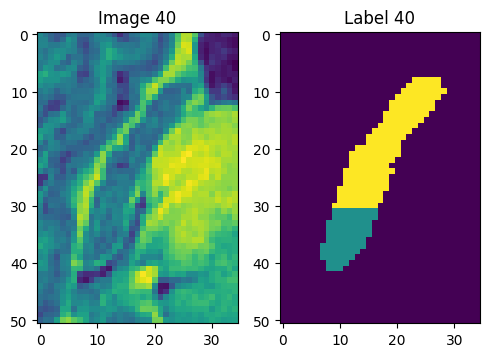

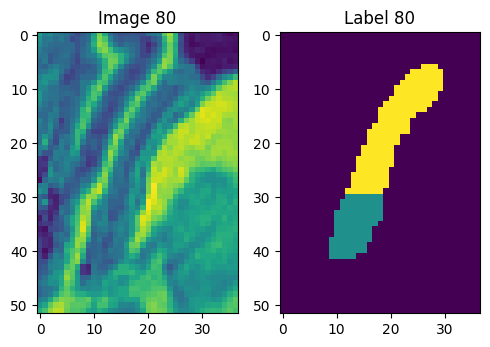

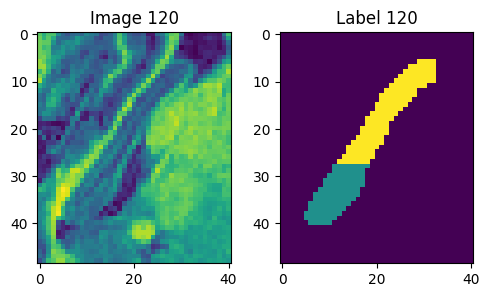

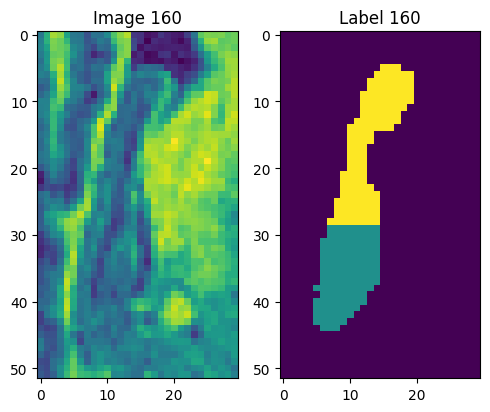

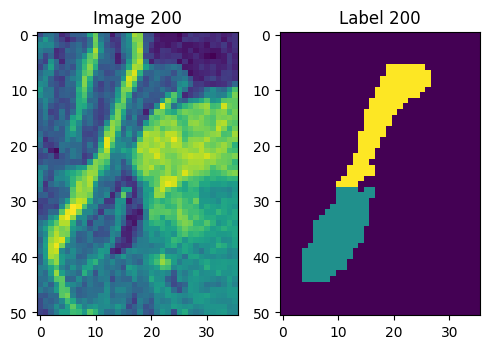

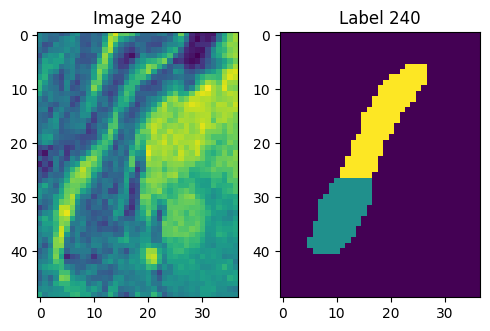

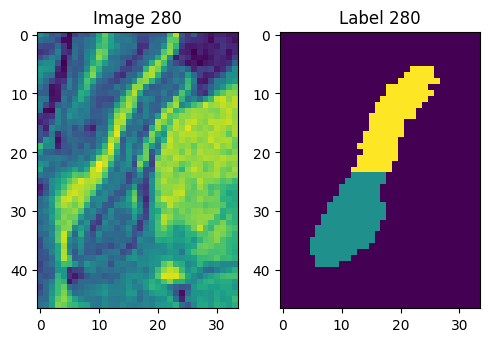

In [7]:
# Function to plot the 14th sagittal slice of images and labels
def plot_slices(images, labels, step):
    num_images = len(images)

    for i in range(0, num_images, step):
        fig, axes = plt.subplots(1, 2, figsize=(5, 5))
        
        # Plot the image slice
        axes[0].imshow(images[i])
        axes[0].set_title(f'Image {i + step}')
        
        # Plot the label slice
        axes[1].imshow(labels[i])
        axes[1].set_title(f'Label {i + step}')
        
        # Adjust layout
        plt.tight_layout()
        plt.show()

# Plot the 14th sagittal slice of each image and label
plot_slices(slice_images, slice_labels, 40)

#### Note:
At this point, we have loaded the 14th sagital slice of each training image and the associated mask. We are next going to ensure every mask lines up in its dimension with the associated image. Masks which do not have the same dimensions cannot be used for training, and the image must be discarded. 

Then, we will set aside a subset (60) of the training images.

In [9]:
if len(images) != len(labels):
    print("The lists do not have the same number of elements.")
else:
    # Iterate over both lists simultaneously
    for i, (array1, array2) in enumerate(zip(slice_images, slice_labels)):
        if array1.shape != array2.shape:
            print(f"Arrays at index {i} do not have the same shape: {array1.shape} != {array2.shape}")
        else:
            # Check each individual image array within the multidimensional array
            all_shapes_match = []
            for j in range(array1.shape[0]):
                for k in range(array1.shape[1]):
                    if array1[j, k].shape != array2[j, k].shape:
                        print(f"Image arrays at index [{i}][{j}][{k}] do not have the same shape: {array1[j, k].shape} != {array2[j, k].shape}")
                        all_shapes_match.append(False)
                    else:
                        all_shapes_match.append(True)
        all(all_shapes_match)

<p>Now we have verified that each corresponding mask and image is the same dimension for sagittal slice #14!</p>

In [32]:
# Spitting off data for evaluation
random.seed(122)
training_indices = sorted(random.sample(list(range(len(slice_images))), 200))
testing_indices = sorted([i for i in list(range(len(slice_labels))) if i not in training_indices])

training_images = [slice_images[i] for i in training_indices]
training_labels = [slice_labels[i] for i in training_indices]
testing_images = [slice_images[i] for i in testing_indices]
testing_labels = [slice_labels[i] for i in testing_indices]

assert(len(training_images) == len(training_labels) and len(testing_images) == len(testing_labels))